# BIA 6304 Text Mining, Fall 2019 - Final Project

### by Sara Lienau

# Table of Contents

- [1. Analyze Frequency of Terms in Article Titles](#1.-Analyze-Frequency-of-Terms-in-Article-Titles)
- [2. Analyze Sentiment of Quotes](#2.-Analyze-Sentiment-of-Quotes)

# Setup for Tasks

### Documentation
- [NLTK](http://www.nltk.org/) - Natural Language Toolkit  
- [Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  
- [Tfidf Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)  
- [Python Sets](http://www.python-course.eu/python3_sets_frozensets.php) - 
good reference for all the set math in python  

In [1]:
# -------------------------------------------------------------------------
# import module(s) into namespace
# -------------------------------------------------------------------------
import pandas as pd
import numpy as np

# # not using right now
#
# from bs4 import BeautifulSoup
# import requests
# import datetime

from sklearn.feature_extraction.text import CountVectorizer
import math

# from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', 1000) #important for getting all the text

import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

### Load - Article Titles

In [2]:
filename = "article_titles.csv"
titles_df = pd.read_csv(filename) 

print("Shape of Corpus is ", titles_df.shape)
titles_df.head()

Shape of Corpus is  (474, 5)


,Extract_Date,Date,Link,Title_Nbr,Title
0,2019-08-29,"Thursday, August 29th",http://createsend.com/t/d-79AF8DD1B5FB119E2540EF23F30FEDED,Title_1,ThoughtSpot Raises $248 Million
1,2019-08-29,"Wednesday, August 28th",http://createsend.com/t/d-A427D2A4C0EFD1F82540EF23F30FEDED,Title_1,Linking EKG Data to Health Status
2,2019-08-29,"Tuesday, August 27th",http://createsend.com/t/d-B503896AA29F56592540EF23F30FEDED,Title_1,Robots May Soon Perform Home Appraisals
3,2019-08-29,"Monday, August 26th",http://createsend.com/t/d-5CCCECDBA202FB562540EF23F30FEDED,Title_1,Huawei Unveils AI Chip
4,2019-08-29,"Friday, August 23rd",http://createsend.com/t/d-B1E4712AB017D6162540EF23F30FEDED,Title_1,Executives Offer Lessons


### Load - Quotes

In [3]:
# -------------------------------------------------------------------------
# setup variables
#   text_column - which column of DataFrame has text of interest
#   corpus_df   - read in desired file of data into DataFrame named "corpus_df"
# -------------------------------------------------------------------------
text_column = 'Quote'
quotes_df   = pd.read_csv("newsletter_quotes.csv") 

corpus_df   = quotes_df

print("Shape of Corpus is ", corpus_df.shape)
#corpus_df.head()
corpus_df.tail()

Shape of Corpus is  (63, 3)


,Date,Quote,Attribution
58,"Thursday, January 17th",If we can achieve true consciousness in machines ... then we can teach them to care.,"David Hanson Jr., founder and Chief Executive Officer of Hanson Robotics Ltd."
59,"Tuesday, January 15th",AI will increasingly replace repetitive jobs. Not just for blue-collar work but a lot of white-collar work.,AI venture capitalist Kai-Fu Lee on CBS's '60 Minutes'
60,"Monday, January 14th","Cognitive labor has shot through the roof. And we can feel it -- so much information, so many choices that demand our attention... No wonder we feel more tired than ever.","I.P. Park, president and chief technology officer of LG Electronics"
61,"Friday, January 11th",The big changes this year versus last year is the humanization of AI and how completely ubiquitous it has become into our lives.,"Allan Cook, the digital reality business leader at Deloitte Digital."
62,"Thursday, January 10th","Golf is the perfect sport for analytics, because everything is a discrete action.","Tom Williams, executive vice president, Arccos, a Stamford, Conn. company that has developed an AI-powered digital caddie."


## Common Functions

In [4]:
# -------------------------------------------------------------------------
# Given data from a vectorizer, return a sorted list of features 
# -------------------------------------------------------------------------
def get_sorted_features(features_array, features_names):
    # count the number of documents where the feature exists
    document_count = np.sum(features_array, axis=0) 

        # convert list to array to sum up feature existence (0,1) (i.e., sum for each column)
        # note: (axis=0 calc/sum by column, axis=1 calc by row)

    df = pd.DataFrame(document_count.tolist(), index=features_names, columns=['Documents'])

        # create a dataframe from the list (note: converting numpy array 'document_count' to a list)

    return df.sort_values(['Documents'], ascending = False) 

# -------------------------------------------------------------------------
# for given feature, return original data from corpus
# -------------------------------------------------------------------------
def search_corpus(feature, df=corpus_df, column_name=text_column):
    search_token_pattern = '(?u)\\b{}\\b'.format(feature)
    return df[df[column_name].str.contains(search_token_pattern, regex=True)]

def search_titles(feature, column_name='Title'):
    return search_corpus(feature, df=titles_df, column_name=column_name)

# 1. Analyze Frequency of Terms in Article Titles

Preprocessing - don't need to expand contractions.  45 tiles (10%) contain apostrophe only 2 are contraction, the rest are a possessive (xxx's)  (Idx 43 - Can't & 208 - Shouldn't)

## Lemmatization
Mostly consolidates plural to singluar form of word.

In [5]:
# -------------------------------------------------------------------------
# Import Lemmatization (as 'wnl')
# -------------------------------------------------------------------------
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

# lemmatize text
titles_df['Title_Lower'] = titles_df['Title'].str.lower()
titles_df['Title_Lem'] = titles_df['Title_Lower'].apply(lambda text: [wnl.lemmatize(word.lower()) for word in text.split()])
titles_df['Title_Lem'] = [" ".join(token) for token in titles_df['Title_Lem']]

# titles_df[titles_df.Title_Lower != titles_df.Title_Lem][['Title', 'Title_Lem']]
titles_df[titles_df.Title_Lower != titles_df.Title_Lem][['Title', 'Title_Lem']].tail()

# affects 305 titles

# couple of misfires
#  11 - as => a
#  12 - uses => us
# 160 - vegas => vega

,Title,Title_Lem
461,Sowing the Seeds of Change in Lawn Care,sowing the seed of change in lawn care
463,AI Drives Business Model Change,ai drive business model change
465,Law Firms Get Productive,law firm get productive
466,Health and Human Services Boosts Investment,health and human service boost investment
469,New Arms Race,new arm race


## Custom Dictionary Replacement

In [6]:
# -------------------------------------------------------------------------
# Custom Dictionary Replacement - function
# -------------------------------------------------------------------------
def multiple_replace(dict, text): 

  """Replace in 'text' all occurences of any key in the given
  dictionary by its corresponding value.  Returns the new tring.""" 
  #text = str(text).lower()

  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

In [7]:
# -------------------------------------------------------------------------
# Custom Dictionary for Article Titles
# -------------------------------------------------------------------------
titles_custom_dict = {
    'facial recognition':'facial-recognition', 
    'machine learning':'machine-learning',
    'self-driving': 'driverless',
    'autonomous vehicle' : 'driverless',
    'algo '      :'algorithm ',
    'algo-'      :'algorithm-',
    'algos'      :'algorithm',
    'neural network' :'neural-network',
    'neural net'     :'neural-network',
    'big data'   :'big-data',
    'big tech'   :'big-tech',
    
    # lemmatization wrong
    'vega' : 'vegas'
}


# -------------------------------------------------------------------------
# Apply to corpus (titles_df)
# -------------------------------------------------------------------------
titles_df['Title_Cleaned'] = titles_df['Title_Lem'].apply(lambda text: multiple_replace(titles_custom_dict, text))

# 36 titles changed

# sample titles that changed
titles_df[titles_df.Title_Lem!=titles_df.Title_Cleaned][['Title_Lem', 'Title_Cleaned']].head()

,Title_Lem,Title_Cleaned
25,lawmaker look to ban facial recognition from public housing,lawmaker look to ban facial-recognition from public housing
41,opposition to police use of facial recognition grows,opposition to police use of facial-recognition grows
49,california may limit police use of facial recognition,california may limit police use of facial-recognition
50,hsbc team up with element ai on big data,hsbc team up with element ai on big-data
57,customer-service algo boost revenue,customer-service algorithm boost revenue


## Custom Stop Word List

In [8]:
# -------------------------------------------------------------------------
# Custom Stop Word List
# -------------------------------------------------------------------------
from sklearn.feature_extraction import stop_words

my_stop_words = set(stop_words.ENGLISH_STOP_WORDS)
# for stopword in stop_words.ENGLISH_STOP_WORDS:
#     my_stop_words.add(stopword)

# remove
my_stop_words.remove('bill')
my_stop_words.remove('fire')

# add 
my_stop_words.add('aim')
my_stop_words.add('effort')
my_stop_words.add('help')
my_stop_words.add('helping')
my_stop_words.add('look')
my_stop_words.add('looking')
my_stop_words.add('push')
my_stop_words.add('make')
my_stop_words.add('making')
my_stop_words.add('million')
my_stop_words.add('new')
my_stop_words.add('raise')
my_stop_words.add('seek')
my_stop_words.add('seeking')
my_stop_words.add('seen')
my_stop_words.add('turn')
my_stop_words.add('use')
my_stop_words.add('using')

# Prevalent Terms Vectorizer

Use custom regex (to include hyphens and abbreviations), 1 word features and limit features to those in a minimum threshold of documents (1% or 5 article titles).

In [9]:
my_token_pattern = "(?u)\\b\\w[\\w\\-.]+\\b"    # keep hyphen & period (for abbreviations)

cv_freq_terms = CountVectorizer(binary=True, lowercase=True,
                      token_pattern=my_token_pattern, 
                      stop_words=my_stop_words,
                      min_df=5,
                      ngram_range=(1,1)
                     ) 

features_freq_terms = cv_freq_terms.fit_transform(titles_df['Title_Cleaned'])

print("Features Detected: ", features_freq_terms.shape[1])

features_names = cv_freq_terms.get_feature_names()

print('\n', features_names)

Features Detected:  35

 ['ai', 'algorithm', 'amazon', 'automation', 'bias', 'business', 'buy', 'car', 'change', 'china', 'company', 'data', 'driverless', 'ethic', 'face', 'facial-recognition', 'firm', 'google', 'health', 'human', 'ibm', 'investment', 'job', 'lead', 'machine-learning', 'microsoft', 'need', 'robot', 'service', 'softbank', 'startup', 'tech', 'test', 'tool', 'u.s']


### Top Features

In [10]:
sorted_count_df=get_sorted_features(features_freq_terms.toarray(), cv_freq_terms.get_feature_names())
sorted_count_df

,Documents
ai,172
robot,25
facial-recognition,17
google,14
tech,13
ethic,13
business,13
algorithm,12
startup,11
data,11


## Search Titles for given Term

In [11]:
search_titles("health", 'Title_Cleaned')[['Title','Date', 'Link']]

,Title,Date,Link
1,Linking EKG Data to Health Status,"Wednesday, August 28th",http://createsend.com/t/d-A427D2A4C0EFD1F82540EF23F30FEDED
22,"Health Care, Sales Software Draw VC Funding","Tuesday, July 30th",http://createsend.com/t/d-A1BD7A3CB179A11F2540EF23F30FEDED
104,Health Agency Launches AI Challenge,"Monday, April 1st",http://createsend.com/t/d-966FFE7CC9E33FD92540EF23F30FEDED
126,Health Providers Develop AI Pathology Tools,"Thursday, February 28th",http://createsend.com/t/d-CB60BD202A582E9F2540EF23F30FEDED
127,Safeway Expands AI Health Clinics,"Wednesday, February 27th",http://createsend.com/t/d-F7543AEA82C99F6D2540EF23F30FEDED
224,Using AI and Wearables to Improve Health Care,"Wednesday, May 29th",http://createsend.com/t/d-4A588D110F7B4D602540EF23F30FEDED
391,Protecting Data in AI Health Systems,"Wednesday, May 15th",http://createsend.com/t/d-4BDE76DC305BEB902540EF23F30FEDED
440,Improving Health Care,"Tuesday, March 5th",http://createsend.com/t/d-69D3E347E03D85602540EF23F30FEDED
466,Health and Human Services Boosts Investment,"Thursday, January 24th",http://createsend.com/t/d-EBF606F5AAA3AFAA2540EF23F30FEDED


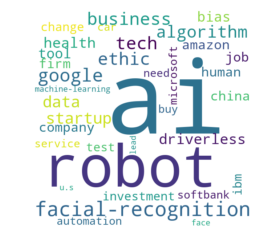

In [12]:
word_freq_dict = sorted_count_df.T.to_dict('records')[0]

wordcloud = WordCloud(width=600, height=600, margin=0,
                      background_color="white")
wordcloud.generate_from_frequencies(word_freq_dict)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0,y=0)
plt.show()

## Explore Terms with Lower Frequency
Terms in 4, 3, 2, 1 documents

In [13]:
my_token_pattern = "(?u)\\b\\w[\\w\\-.]+\\b"    # keep hyphen & period (for abbreviations)

cv_less = CountVectorizer(binary=True, lowercase=False,
                      token_pattern=my_token_pattern, 
                      stop_words=my_stop_words,
                      min_df=2, max_df=3,
                      ngram_range=(1,1)
                     ) 

features_cv_less = cv_less.fit_transform(titles_df['Title_Cleaned'])

print("Features Detected: ", features_cv_less.shape[1])
# Terms in 4 document - 24 word
# ['better', 'boost', 'care', 'center', 'challenge', 'creating', 'debate', 'delivery', 'demand', 'expert',
#  'facebook', 'fighting', 'fraud', 'limit', 'maker', 'plan', 'police', 'question', 'security', 'set', 'talent',
#  'team', 'voice', 'worker']

# 3 -  50
# 2 - 132
# 1 - 681
features_names = cv_less.get_feature_names()

print('\n', features_names)

Features Detected:  182

 ['abuse', 'academic', 'acquisition', 'add', 'address', 'adoption', 'adversarial', 'ahead', 'ai-driven', 'ai-powered', 'angle', 'anthem', 'anxiety', 'app', 'apple', 'approach', 'assistant', 'automating', 'ban', 'bank', 'benefit', 'best', 'big', 'big-tech', 'bill', 'billion', 'board', 'bolster', 'boom', 'boosting', 'bot', 'brain', 'build', 'case', 'ceo', 'changing', 'chatbot', 'chief', 'chip', 'cio', 'cloud', 'collaboration', 'coming', 'compete', 'complex', 'concern', 'congress', 'cosmetic', 'cost', 'council', 'course', 'customer', 'cyber', 'deal', 'decision', 'deepfakes', 'defense', 'deploy', 'detect', 'detection', 'development', 'device', 'director', 'disrupting', 'drain', 'drive', 'emotion', 'end', 'engineer', 'ethicist', 'eu', 'europe', 'executive', 'eye', 'fda', 'financial', 'finding', 'fire', 'fix', 'flood', 'forecasting', 'fuel', 'fund', 'future', 'gadget', 'giant', 'good', 'high-tech', 'hire', 'home', 'house', 'huawei', 'improve', 'improves', 'improving'

In [14]:
search_titles('spending', 'Title_Cleaned')[['Title', 'Title_Cleaned', 'Date', 'Link']]

# Interesting Terms in 2 
# - board, ceo, cio, chief, executive, managers/managing ... project ... strategy
# market, investor
#
# predicting 
#
# Lie, Abuse, Adversarial, Responsible, Surveillance
# Decisions

# Relevant to Parent Company
# - Trucking / Trucking Enters Era of AI
#   http://createsend.com/t/d-37FA888204C1F1642540EF23F30FEDED
#   # predictive maintenance
# (Rail, Construction)
#   Rail Operators See AI Benefits
#   http://createsend.com/t/d-A10A89C0AF58A7042540EF23F30FEDED
#   https://www.wsj.com/articles/ai-yields-benefits-for-rail-operators-11556616600?mod=djemAIPro

# Industries
# - Banks, Cosmetics, Retailers 
# Companies
# - Anthem, Apple, Huawei, Softbank, Stanford, Toyota, Twitter, Uber, VA
# Gov't
# - Congress, EU, FDA, (Europe), OECD

,Title,Title_Cleaned,Date,Link
116,AI Spending to Double by 2022,ai spending to double by 2022,"Thursday, March 14th",http://createsend.com/t/d-37AC3C321823439D2540EF23F30FEDED
209,AI Spending,ai spending,"Wednesday, June 19th",http://createsend.com/t/d-54C4D27FB26412E82540EF23F30FEDED
251,AI Boosts Software Spending,ai boost software spending,"Thursday, April 18th",http://createsend.com/t/d-BCAE4EECE8415AE42540EF23F30FEDED


# 2. Analyze Sentiment of Quotes

## Load Quotes

In [15]:
# # -------------------------------------------------------------------------
# # setup variables
# #   text_column - which column of DataFrame has text of interest
# #   corpus_df   - read in desired file of data into DataFrame named "corpus_df"
# # -------------------------------------------------------------------------
# text_column = 'Quote'
# quotes_df   = pd.read_csv("newsletter_quotes.csv") 

# corpus_df   = quotes_df

# print("Shape of Corpus is ", corpus_df.shape)
# #corpus_df.head()
corpus_df.tail(3)

,Date,Quote,Attribution
60,"Monday, January 14th","Cognitive labor has shot through the roof. And we can feel it -- so much information, so many choices that demand our attention... No wonder we feel more tired than ever.","I.P. Park, president and chief technology officer of LG Electronics"
61,"Friday, January 11th",The big changes this year versus last year is the humanization of AI and how completely ubiquitous it has become into our lives.,"Allan Cook, the digital reality business leader at Deloitte Digital."
62,"Thursday, January 10th","Golf is the perfect sport for analytics, because everything is a discrete action.","Tom Williams, executive vice president, Arccos, a Stamford, Conn. company that has developed an AI-powered digital caddie."


## Preprocess Text

In [16]:
# ------------------------------------------------------------------------
# Custom Stop Words List
# -------------------------------------------------------------------------
from sklearn.feature_extraction import text    # import package
stopwords_skl  = text.ENGLISH_STOP_WORDS       # pull out words in sklearn stopwords list

stopwords_custom = list(stopwords_skl)

# words to keep
stopwords_custom.remove('not')
stopwords_custom.remove('no')

# ------------------------------------------------------------------------
# Setup for Contractions
# -------------------------------------------------------------------------
# code borrowed from http://stackoverflow.com/questions/27845796/replacing-words-matching-regular-expressions-in-python
import re

replacement_patterns = [
(r'won\'t', 'will not'),
(r'can\'t', 'cannot'),
(r'i\'m', 'i am'),
(r'ain\'t', 'is not'),
(r'(\w+)\'ll', '\g<1> will'),
(r'(\w+)n\'t', '\g<1> not'),
(r'(\w+)\'ve', '\g<1> have'),
(r'(\w+)\'s',  '\g<1> is'),
(r'(\w+)\'re', '\g<1> are'),
(r'(\w+)\'d',  '\g<1> would')
]

class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
            (s, count) = re.subn(pattern, repl, s)
        return s

# ------------------------------------------------------------------------
# Expand Contractions
# -------------------------------------------------------------------------
replacer = RegexpReplacer()
corpus_df['Quote_Cleaned'] = corpus_df['Quote'].map(lambda x: replacer.replace(x))

# ------------------------------------------------------------------------
# Exclude Stop Words
# -------------------------------------------------------------------------
from nltk import word_tokenize

def exclude_stopwords(text, stopwords):
    return ' '.join([word for word in text.split() if word.lower() not in stopwords])

corpus_df['Quote_Cleaned'] = corpus_df['Quote_Cleaned'].map(lambda text: exclude_stopwords(text, stopwords_custom))

# -------------------------------------------------------------------------
# Import Lemmatization (as 'wnl')
# -------------------------------------------------------------------------
# lemmatizing - tries to make sense of things instead of chopping them down
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

# lemmatize the current version of the cleaned up text

corpus_df['Quote_Lem'] = corpus_df['Quote_Cleaned'].apply(lambda x: [wnl.lemmatize(y) for y in x.split()])
corpus_df['Quote_Lem'] = [" ".join(token) for token in corpus_df['Quote_Lem']]

In [17]:
corpus_df.head(3)

,Date,Quote,Attribution,Quote_Cleaned,Quote_Lem
0,"Wednesday, August 28th","I think that almost no government is prepared to make policy in the right ways on a lot of the questions that are confronting us as a result of AI development, and I think that it's mostly because government lacks the capacity -- the technical capacity -- to understand what's happening in the field effectively and translate that into effective policy measures.","Terah Lyons, executive director of the Partnership on AI, in an interview with VentureBeat.","think no government prepared make policy right ways lot questions confronting result AI development, think government lacks capacity -- technical capacity -- understand happening field effectively translate effective policy measures.","think no government prepared make policy right way lot question confronting result AI development, think government lack capacity -- technical capacity -- understand happening field effectively translate effective policy measures."
1,"Tuesday, August 27th",Software is eating real estate.,"Jeremy Sicklick, chief executive of HouseCanary Inc., which has trained computers to assess the condition of homes using photos and sometimes employs drones to produce images of properties.",Software eating real estate.,Software eating real estate.
2,"Monday, August 26th","No matter what the U.S. does now, Huawei is on a mission to become self-sufficient and not beholden to the whims of the U.S. president.","Mark Newman, an analyst at Bernstein Research.","No matter U.S. does now, Huawei mission self-sufficient not beholden whims U.S. president.","No matter U.S. doe now, Huawei mission self-sufficient not beholden whim U.S. president."


## 2A. Add Negation Logic in Sentiment Assignment Function

In [18]:
# ------------------------------------------------------------------------
# First, check how many quotes contain No or Not.  Is it enough to warrant the effort?
# -------------------------------------------------------------------------

#search_corpus("Not", column_name='Quote_Lem')[['Quote', 'Quote_Cleaned', 'Quote_Lem']]

print("How many of the 63 quotes contain 'no' or 'not' terms?")
print("contains not", len(search_corpus("not", column_name='Quote_Lem')))
print("contains Not", len(search_corpus("Not", column_name='Quote_Lem')))
print("contains no ", len(search_corpus("no",  column_name='Quote_Lem')))
print("contains No ", len(search_corpus("No",  column_name='Quote_Lem')))

# about 18 of 63 (or 28.6%  - one quote Idx 2 contains No and not)

How many of the 63 quotes contain 'no' or 'not' terms?
contains not 15
contains Not 1
contains no  1
contains No  2


### Load NRC Emotion Lexicon Sentiment Dictionary

In [19]:
filepath = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=38, sep='\t')
#emolex_df.head(10)

# ------------------------------------------------------------------------
# Create NRC/default Lexicon Emotion Association (DataFrame)
# ------------------------------------------------------------------------

# find words associated with an emotion/sentiment
nrc_emolex_assoc_df = emolex_df[emolex_df.association==1][['word', 'emotion']]

### Create Functions to Assignment Sentiment

- **emolex_sentiment** - flavor used in Assignment 2
- **emolex_sentiment_negation** - contains negation logic

In [20]:
# Weight/Scoring of Emotion to drive a sentiment label
#
# Emotion        Words      My Sentiment / My Weight
#
# negative        3324      neg -1
# positive        2312      pos  1
# fear            1476      neg -2
# anger           1247      neg -2
# trust           1231      pos +2
# sadness         1191      neg  1
# disgust         1058      neg -3
# anticipation     839      pos  1
# joy              689      pos +3
# surprise         534      pos +3

emolex_emotion_weight = {
    'negative'     : -1,
    'positive'     :  1,
    'fear'         : -2,
    'anger'        : -2,
    'trust'        :  2,
    'sadness'      : -1,
    'disgust'      : -3,
    'anticipation' :  1, 
    'joy'          :  3,
    'surprise'     :  3  
}


# ------------------------------------------------------------------------
# Original function from Assignment 2
# ------------------------------------------------------------------------
def emolex_sentiment(text, emolex_assoc):  
    text_score=0
    emotion_set=set()
    word_emotion_list=[]
    
    for word in text.split():
        word = word.lower().rstrip('?:!.,;')
        
        # find related emotions in sentiment dictionary
        emotions = emolex_assoc[emolex_assoc.word==word].emotion
        for emotion in emotions:
            
            # look up weight value for emotion and add it to the running score
            word_emotion_weight = emolex_emotion_weight.get(emotion, 0)
            text_score += word_emotion_weight
            
            # collect the emotions associated with text
            emotion_set.add(emotion)
            
            # and the word/emotion pair
            word_emotion_list.append("{}={}".format(word, emotion))

    if (len(word_emotion_list)) == 0:
        sentiment_label = 'Mystery'  # no words in text found in sentiment dictionary
    elif (text_score < 0):
        sentiment_label = 'Negative'
    elif (text_score > 0):
        sentiment_label = 'Positive'
    else:
        sentiment_label = 'Neutral'

    return [sentiment_label, sorted(emotion_set), word_emotion_list, text_score]

# ------------------------------------------------------------------------
# Function with Negation Logic
# ------------------------------------------------------------------------
def emolex_sentiment_negation(text, emolex_assoc):  
    text_score=0
    emotion_set=set()
    word_emotion_list=[]
    
    negation_factor = 1
    
    for word in text.split():
        word = word.lower().rstrip('?:!.,;')
        
        # find related emotions in sentiment dictionary
        emotions = emolex_assoc[emolex_assoc.word==word].emotion
        for emotion in emotions:
            
            # look up weight value for emotion and add it to the running score
            word_emotion_weight = emolex_emotion_weight.get(emotion, 0)
            text_score += (word_emotion_weight * negation_factor)
            
            # collect the emotions associated with text
            emotion_set.add(emotion)
            
            # and the word/emotion pair
            # denote that we negative the weight of the emotion by preceding the term with hat/carat (^)
            negation_symbol = "^" if (negation_factor == -1) else ""
            word_emotion_list.append("{}{}={}".format(negation_symbol, word, emotion))
            
        if (word in ['no', 'not']):
            negation_factor = -1
        else:
            negation_factor = 1

    if (len(word_emotion_list)) == 0:
        sentiment_label = 'Mystery'  # no words in text found in sentiment dictionary
    elif (text_score < 0):
        sentiment_label = 'Negative'
    elif (text_score > 0):
        sentiment_label = 'Positive'
    else:
        sentiment_label = 'Neutral'

    return [sentiment_label, sorted(emotion_set), word_emotion_list, text_score]

In [21]:
# Test function on some examples and review output
sample_text = "good AI ridiculously unfair advantage humans: not tired. not hungry. not deal emotions"
#sample_text = "Cognitive labor shot roof. feel -- information, choice demand attention... No wonder feel tired ever"

print("Original")
print(emolex_sentiment(sample_text, nrc_emolex_assoc_df))
print("\n~~~~~~~~~~~~~~~\n")
print("With Negation Logic")
print(emolex_sentiment_negation(sample_text, nrc_emolex_assoc_df))

# a ^ preceding term means the weight was negated.
# the function negated the weight of emotions associated with the following terms
# - tired, hungry, & deal

Original
['Positive', ['anger', 'anticipation', 'disgust', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'], ['good=anticipation', 'good=joy', 'good=positive', 'good=surprise', 'good=trust', 'unfair=anger', 'unfair=disgust', 'unfair=negative', 'unfair=sadness', 'advantage=positive', 'tired=negative', 'hungry=anticipation', 'hungry=negative', 'deal=anticipation', 'deal=joy', 'deal=positive', 'deal=surprise', 'deal=trust'], 13]

~~~~~~~~~~~~~~~

With Negation Logic
['Negative', ['anger', 'anticipation', 'disgust', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'], ['good=anticipation', 'good=joy', 'good=positive', 'good=surprise', 'good=trust', 'unfair=anger', 'unfair=disgust', 'unfair=negative', 'unfair=sadness', 'advantage=positive', '^tired=negative', '^hungry=anticipation', '^hungry=negative', '^deal=anticipation', '^deal=joy', '^deal=positive', '^deal=surprise', '^deal=trust'], -5]


### Apply Sentiment Assignment Functions to Quote Text

In [22]:
# ------------------------------------------------------------------------
# Apply Sentiment Assignment Functions to preprocessed version of quote text
# ------------------------------------------------------------------------
corpus_df['emolex_Lem']   = corpus_df['Quote_Lem'].apply(lambda text: emolex_sentiment(text, nrc_emolex_assoc_df))

# break out interesting pieces calculated by emolex_sentiment()
corpus_df['Sentiment_Orig']    = [item[0] for item in corpus_df['emolex_Lem']]
#corpus_df['Emotions']     = [" ".join(item[1]) for item in corpus_df['emolex_Lem']]
corpus_df['Score_Orig']        = [item[3] for item in corpus_df['emolex_Lem']]
#corpus_df['Word_Emotion_Match_Orig']  = [item[2] for item in corpus_df['emolex_Lem']]

corpus_df['emolex_neg_Lem']   = corpus_df['Quote_Lem'].apply(lambda text: emolex_sentiment_negation(text, nrc_emolex_assoc_df))
corpus_df['Sentiment']    = [item[0] for item in corpus_df['emolex_neg_Lem']]
corpus_df['Emotions']     = [" ".join(item[1]) for item in corpus_df['emolex_neg_Lem']]
corpus_df['Score']        = [item[3] for item in corpus_df['emolex_neg_Lem']]
corpus_df['Word_Emotion_Match']  = [item[2] for item in corpus_df['emolex_neg_Lem']]

## Compare Results of Sentiment Assignment Functions (with & without negation logic)

The **Sentiment Label** assigned to quote only changed on 1 quote.  The function negated the weight of emotions associated with the following terms: tired, hungry, deal.  The score flipped from 13 to -5.  A big change!

>*"A good AI has a ridiculously unfair advantage against humans: They don't get tired. They don't get hungry. They don't deal with emotions."* (Idx 11)

In [23]:
# ------------------------------------------------------------------------
# Compare resulting SENTIMENT LABEL using different sentiment assignment functions
# ------------------------------------------------------------------------
corpus_df[corpus_df.Sentiment_Orig != corpus_df.Sentiment] \
    [['Quote', 'Sentiment_Orig', 'Sentiment', 'Score', 'Score_Orig', 'Emotions', 'Word_Emotion_Match']]

,Quote,Sentiment_Orig,Sentiment,Score,Score_Orig,Emotions,Word_Emotion_Match
11,A good AI has a ridiculously unfair advantage against humans: They don't get tired. They don't get hungry. They don't deal with emotions.,Positive,Negative,-5,13,anger anticipation disgust joy negative positive sadness surprise trust,"[good=anticipation, good=joy, good=positive, good=surprise, good=trust, unfair=anger, unfair=disgust, unfair=negative, unfair=sadness, advantage=positive, ^tired=negative, ^hungry=anticipation, ^hungry=negative, ^deal=anticipation, ^deal=joy, ^deal=positive, ^deal=surprise, ^deal=trust]"


The **Sentiment Score** assigned changed on **6 quotes**.  (Quote Idx 11 where label, changed plus 5 other quotes).

On 4 of the 5 quotes the score is **more** positive because the negation (no/not) precedes a term association with a negate emotion.

In [24]:
# ------------------------------------------------------------------------
# Compare resulting SENTIMENT SCORE using different sentiment assignment functions
# ------------------------------------------------------------------------
corpus_df[corpus_df.Score_Orig != corpus_df.Score] \
    [['Quote', 'Sentiment_Orig', 'Sentiment', 'Score', 'Score_Orig', 'Word_Emotion_Match']]

# score on 6 quotes changed
# generally made things more positive - negating terms with negative sentiment/emotion

,Quote,Sentiment_Orig,Sentiment,Score,Score_Orig,Word_Emotion_Match
0,"I think that almost no government is prepared to make policy in the right ways on a lot of the questions that are confronting us as a result of AI development, and I think that it's mostly because government lacks the capacity -- the technical capacity -- to understand what's happening in the field effectively and translate that into effective policy measures.",Positive,Positive,12,6,"[^government=fear, ^government=negative, prepared=anticipation, prepared=positive, prepared=trust, policy=trust, question=positive, result=anticipation, government=fear, government=negative, lack=negative, effective=positive, effective=trust, policy=trust]"
2,"No matter what the U.S. does now, Huawei is on a mission to become self-sufficient and not beholden to the whims of the U.S. president.",Positive,Positive,10,8,"[^beholden=negative, whim=anticipation, whim=joy, whim=negative, whim=surprise, president=positive, president=trust]"
6,"If you are going to be using public data and especially for public purposes, then we shouldn't have a black box sort of AI system.",Positive,Positive,8,4,"[public=anticipation, public=positive, public=anticipation, public=positive, ^black=negative, ^black=sadness, system=trust]"
11,A good AI has a ridiculously unfair advantage against humans: They don't get tired. They don't get hungry. They don't deal with emotions.,Positive,Negative,-5,13,"[good=anticipation, good=joy, good=positive, good=surprise, good=trust, unfair=anger, unfair=disgust, unfair=negative, unfair=sadness, advantage=positive, ^tired=negative, ^hungry=anticipation, ^hungry=negative, ^deal=anticipation, ^deal=joy, ^deal=positive, ^deal=surprise, ^deal=trust]"
12,"AI is only as good as the humans programming it and the system in which it operates. If we are not careful, AI could not make healthcare better, but instead unintentionally exacerbate many of the worst aspects of our current healthcare system.",Positive,Positive,12,14,"[good=anticipation, good=joy, good=positive, good=surprise, good=trust, ^careful=positive, unintentionally=negative, unintentionally=surprise, exacerbate=negative, system=trust]"
44,"As much as I love Elon, and he's a great entrepreneur and a friend, his comic-book vision of a future in which an artificial superintelligence takes over everything and enslaves the human race is probably not what we should be worrying about.",Positive,Positive,15,9,"[love=joy, love=positive, friend=joy, friend=positive, friend=trust, vision=anticipation, vision=positive, ^worrying=anticipation, ^worrying=fear, ^worrying=negative, ^worrying=sadness]"


**For the remaining 12 quotes** (contain a no/not term), **why is there no change** at least the sentiment score?

No/not precedes a term that is not found in the sentiment dictionary, so there is no impact (i.e., no emotion weight to negate).

In [25]:
# ------------------------------------------------------------------------
# Explore Quote with a Negation term but no change in Sentiment Score
# ------------------------------------------------------------------------
search_corpus("not", column_name='Quote_Lem')[['Quote_Lem', 'Score', 'Score_Orig', 'Word_Emotion_Match']].tail(4)

# 6 that changed - 0, 2, 6, 11, 12, 44

,Quote_Lem,Score,Score_Orig,Word_Emotion_Match
52,"genie bottle. AI technology play company going use it, not remain competitive. going create skill gap. Companies need prepared massive retraining lie ahead.",2,2,"[technology=positive, create=joy, create=positive, gap=negative, prepared=anticipation, prepared=positive, prepared=trust, lie=anger, lie=disgust, lie=negative, lie=sadness, ahead=positive]"
53,"think well-informed citizen 21st century, need know little bit stuff [AI] want able participate debates. not want AI sort thing happens you.",1,1,[citizen=positive]
55,"CIO organization doe not use AI, chance high competitor concern.",13,13,"[organization=anticipation, organization=joy, organization=positive, organization=surprise, organization=trust, chance=surprise]"
56,"new surveillance technology applied population not going object: prisoners, children, immigrants. ask want raise generation used growing environment electronically monitored AI agents.",0,0,"[surveillance=fear, technology=positive, population=positive]"


## 2B. Expand Terms in NRC (from AFINN & HL dictionaries)

### Load AFINN & HL Sentiment Dictionaries

In [26]:
# -------------------------------------------------------------------------
# Load AFINN Sentiment Dictionary
# -------------------------------------------------------------------------
afinn = {}
for line in open("AFINN-111.txt"):
    tt = line.split('\t')
    afinn.update({tt[0]:int(tt[1])})  # add term (as key to dict item) & value as int
# -------------------------------------------------------------------------
# Load HL Sentiment Dictionary
# -------------------------------------------------------------------------
# I merged positive and negative list together and assign value of 1 or -1
# -------------------------------------------------------------------------
huliu = {}
for line in open('HLpos.txt','r'):
    huliu.update({line.strip():int(1)})
for line in open('HLneg.txt','r',encoding = 'latin-1'):
    huliu.update({line.strip():int(-1)})

### Find Terms in AFINN & HL that do not exist in NRC
**Result** added 42 additional terms NRC EmoLex

In [27]:
# -------------------------------------------------------------------------
# Use Count Vectorizer with custom regex (which keeps hyphen & period (for abbreviations))
# -------------------------------------------------------------------------
my_token_pattern = "(?u)\\b\\w[\\w\\-.]+\\b"    # keep hyphen & period (for abbreviations)

cv_my_regex = CountVectorizer(binary=True, token_pattern=my_token_pattern) 

my_regex_dm = cv_my_regex.fit_transform(corpus_df['Quote_Lem'])

features_names_my_regex = cv_my_regex.get_feature_names()
features_names = features_names_my_regex

print("{} Documents and {} Features".format(my_regex_dm.shape[0], my_regex_dm.shape[1]))

terms_set = set(features_names_my_regex)

# -------------------------------------------------------------------------
# Compare with AFINN
# -------------------------------------------------------------------------
afinn_set = set(afinn.keys())

terms_in_AFINN = terms_set.intersection(afinn_set)
terms_missing_AFINN = terms_set.difference(afinn_set)

print("\n")
print("Corpus Terms       in AFINN: {}".format(len(terms_in_AFINN)))
print("Corpus Terms *NOT* in AFINN: {}".format(len(terms_missing_AFINN)))

# -------------------------------------------------------------------------
# Compare with Hu and Liu
# -------------------------------------------------------------------------
huliu_set = set(huliu.keys())

terms_in_huliu      = terms_set.intersection(huliu_set)
terms_missing_huliu = terms_set.difference(huliu_set)

print("\n")
print("Corpus Terms       in HuLiu: {}".format(len(terms_in_huliu)))
print("Corpus Terms *NOT* in HuLiu: {}".format(len(terms_missing_huliu)))

# -------------------------------------------------------------------------
# Compare with NRC Emotion Lexicon
# -------------------------------------------------------------------------
emolex_words = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
nrc_set = set(emolex_words.word)

terms_in_EmoLex      = terms_set.intersection(nrc_set)
terms_missing_EmoLex = terms_set.difference(nrc_set)

print("\n")
print("Corpus Terms       in EmoLex: {}".format(len(terms_in_EmoLex)))
print("Corpus Terms *NOT* in EmoLex: {}".format(len(terms_missing_EmoLex)))


print("\n")
terms_addl_huliu = terms_missing_EmoLex.intersection(terms_in_huliu)
print("{} terms in Hu Liu can be added to NRC".format(len(terms_addl_huliu)))
print(terms_addl_huliu)

terms_addl_afinn = terms_missing_EmoLex.difference(terms_in_huliu).intersection(terms_in_AFINN) 

print("\n")
print("{} terms in AFINN can be added to NRC".format(len(terms_addl_afinn)))
print(terms_addl_afinn)


# -------------------------------------------------------------------------
# Create a DataFrame of additional terms and positive/negative sentiment from original dictionary
# -------------------------------------------------------------------------
words = []
emotions = []

for word in terms_addl_huliu:
    words.append(word)
    word_score = huliu.get(word, 0)
    if word_score > 0:
        emotions.append('positive')
    else:
        emotions.append('negative')

terms_addl_afinn.remove('no')
for word in terms_addl_afinn:
    words.append(word)
    word_score = afinn.get(word, 0)
    if word_score > 0:
        emotions.append('positive')
    else:
        emotions.append('negative')

additional_terms_df = pd.DataFrame({"word":words, "emotion":emotions})
additional_terms_df[10:20]

63 Documents and 503 Features


Corpus Terms       in AFINN: 69
Corpus Terms *NOT* in AFINN: 434


Corpus Terms       in HuLiu: 82
Corpus Terms *NOT* in HuLiu: 421


Corpus Terms       in EmoLex: 290
Corpus Terms *NOT* in EmoLex: 213


32 terms in Hu Liu can be added to NRC
{'smarter', 'troubling', 'strongest', 'slowed', 'authoritarian', 'effectively', 'recover', 'threats', 'fail', 'self-sufficient', 'ridiculously', 'well-informed', 'repetitive', 'right', 'failed', 'best', 'free', 'better', 'unwieldy', 'cost-effective', 'worst', 'problems', 'wonder', 'like', 'critical', 'wow', 'disruptive', 'great', 'false', 'helping', 'clear', 'effectiveness'}


10 terms in AFINN can be added to NRC
{'no', 'prisoners', 'growing', 'want', 'solves', 'help', 'enslaves', 'shared', 'allow', 'certain'}


,word,emotion
10,ridiculously,negative
11,well-informed,positive
12,repetitive,negative
13,right,positive
14,failed,negative
15,best,positive
16,free,positive
17,better,positive
18,unwieldy,negative
19,cost-effective,positive


In [28]:
# -------------------------------------------------------------------------
# Merge original NRC Lexicon(Term) and Emotion association together with 
# additional terms/emotion from AFINN/HL
# -------------------------------------------------------------------------

print("Shape of emolex_assoc_df    ", nrc_emolex_assoc_df.shape)
#13901

print("Shape of additional_terms_df", additional_terms_df.shape)
#   42

my_emolex_assoc_df = pd.concat([nrc_emolex_assoc_df, additional_terms_df])

print("Shape of my_emolex_assoc_df ", my_emolex_assoc_df.shape)

Shape of emolex_assoc_df     (13901, 2)
Shape of additional_terms_df (41, 2)
Shape of my_emolex_assoc_df  (13942, 2)


### Apply Sentiment Assignment Function (with negation logic) ...
### But now use my expanded NRC EmoLex dictionary

In [29]:
# ------------------------------------------------------------------------
# Apply Sentiment Assignment Functions to preprocessed version of quote text
# ------------------------------------------------------------------------
corpus_df['emolex_neg_Lem']   = corpus_df['Quote_Lem'].apply(lambda text: emolex_sentiment_negation(text, my_emolex_assoc_df))
corpus_df['Sentiment']    = [item[0] for item in corpus_df['emolex_neg_Lem']]
corpus_df['Emotions']     = [" ".join(item[1]) for item in corpus_df['emolex_neg_Lem']]
corpus_df['Score']        = [item[3] for item in corpus_df['emolex_neg_Lem']]
corpus_df['Word_Emotion_Match']  = [item[2] for item in corpus_df['emolex_neg_Lem']]

## Compare Results of Assigment 2 Sentiment Function with ...
## Negation Logic & Slightly Larger NRC EmoLex dictionary

Now **7 quotes** are assigned a **different sentiment label** and **33 quotes** (over half) have a **different sentiment score**.

In [30]:
# ------------------------------------------------------------------------
# Get Counts of # Quote where there's a change in Label or Score
# ------------------------------------------------------------------------
# print(len(corpus_df[corpus_df.Sentiment_Orig != corpus_df.Sentiment] \
# [['Quote', 'Sentiment_Orig', 'Sentiment', 'Score', 'Score_Orig', 'Emotions', 'Word_Emotion_Match']]))
# #  7 quotes have a different sentiment label
# # 33 quotes have a different score

### On Label Changes ...
- 1 is Idx 11 - the Positive => Negative change do to negation logic.
- 3 "Mystery" quotes not match on 1 term.  So that allows the function to assign a label but it is a very weak association as indicated by the score (0 => 1 / -1)
- The rest, we pick up another term and it shifts the balance shift (score different is usually 0 => 1/-1 or vice versa.

**So the score is probably important to keep in mind - how much faith to put the associated label.**

In [31]:
corpus_df[corpus_df.Sentiment_Orig != corpus_df.Sentiment] \
    [['Quote', 'Sentiment_Orig', 'Sentiment', 'Score', 'Score_Orig', 'Emotions', 'Word_Emotion_Match']]

# 3 Mystery - now have a matching term in sentiment dictionary so some weight can be considered.
#   Idx  5 - OK, an improvement
#   Idx 13 - kind of weak - trigger on term "want", score is appropriate just a 1 
#   Idx 59 - similar to 13 - match on 1 term, and have a weak signal/score (-1)
# 2 Neutral - now have add'l. term(s) that shifts the balance
#   Idx 10 - This one feels more negative to me (new term 'recover' tips the balance)
#   Idx 56 - Again more negative
# 1 - Positive => Negative (due to negation logic)
# 1 - Negative to Neutral (Score goes from 0 to -1)

# for all the Mystery/Neutral changes the movement in the score is tiny - just 1.  
# The additional terms tip the balance not by much.

,Quote,Sentiment_Orig,Sentiment,Score,Score_Orig,Emotions,Word_Emotion_Match
5,"These platforms have been weaponized, and these aren't hypothetical threats.",Mystery,Negative,-1,0,negative,[threats=negative]
10,"If you really fumble on the first one or two projects, it may take you a couple of years or even longer to recover and start again.",Neutral,Positive,1,0,anticipation negative positive,"[fumble=negative, recover=positive, start=anticipation]"
11,A good AI has a ridiculously unfair advantage against humans: They don't get tired. They don't get hungry. They don't deal with emotions.,Positive,Negative,-6,13,anger anticipation disgust joy negative positive sadness surprise trust,"[good=anticipation, good=joy, good=positive, good=surprise, good=trust, ridiculously=negative, unfair=anger, unfair=disgust, unfair=negative, unfair=sadness, advantage=positive, ^tired=negative, ^hungry=anticipation, ^hungry=negative, ^deal=anticipation, ^deal=joy, ^deal=positive, ^deal=surprise, ^deal=trust]"
13,"That's the last thing I want to do, is have robots make pizzas.",Mystery,Positive,1,0,positive,[want=positive]
14,The effectiveness of AI has been very much exaggerated.,Negative,Neutral,0,-1,negative positive,"[effectiveness=positive, exaggerated=negative]"
56,"We often see new surveillance technologies first applied to populations that are not going to object: prisoners, children, immigrants. You have to ask whether you want to raise a generation that is used to growing up in environments where they're electronically monitored by AI agents.",Neutral,Positive,1,0,fear negative positive,"[surveillance=fear, technology=positive, population=positive, prisoners=negative, want=positive, growing=positive]"
59,AI will increasingly replace repetitive jobs. Not just for blue-collar work but a lot of white-collar work.,Mystery,Negative,-1,0,negative,[repetitive=negative]


### On Score Changes ...

Looks like most a minor shift -1 or +1, but sometimes a bigger changes in the scores.  Just from scanning results, it looks like bigger change in score comes when negated terms are in the mix.

count    33.000000
mean      0.242424
std       4.115749
min     -19.000000
25%      -1.000000
50%       1.000000
75%       1.000000
max       8.000000
Name: Score_Diff, dtype: float64


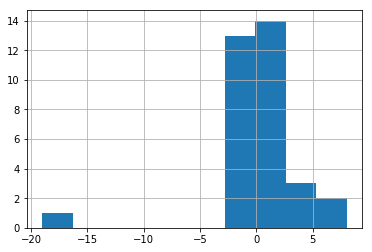

In [32]:
# ------------------------------------------------------------------------
# Calculate the Difference in the score - how much does it change?
# ------------------------------------------------------------------------
corpus_df['Score_Diff'] = corpus_df.Score - corpus_df.Score_Orig

# summary statistics
print(corpus_df[corpus_df.Score_Orig != corpus_df.Score].Score_Diff.describe())

# histogram
corpus_df[corpus_df.Score_Orig != corpus_df.Score].Score_Diff.hist(bins=10)

In [33]:
# ------------------------------------------------------------------------
# Explore Examples
# ------------------------------------------------------------------------

# corpus_df[corpus_df.Score_Diff > 2 ] \
#      [['Quote', 'Sentiment_Orig', 'Sentiment', 'Score', 'Score_Orig', 'Score_Diff', 'Emotions', 'Word_Emotion_Match']] 

# just observation from scanning results - larger differences, included negated terms.

Stats on Original Sentiment Approach
Positive    42
Negative    12
Mystery      6
Neutral      3
Name: Sentiment_Orig, dtype: int64

~~~~~~~~~~~~~~~

Stats on Final Sentiment Approach
Positive    44
Negative    14
Mystery      3
Neutral      2
Name: Sentiment, dtype: int64

~~~~~~~~~~~~~~~

count    63.000000
mean      3.603175
std       7.798965
min     -23.000000
25%       0.000000
50%       3.000000
75%       8.500000
max      24.000000
Name: Score, dtype: float64


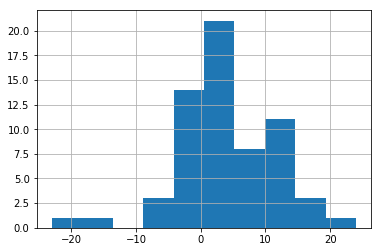

In [34]:
print("Stats on Original Sentiment Approach")
print(corpus_df.Sentiment_Orig.value_counts())
print("\n~~~~~~~~~~~~~~~\n")

print("Stats on Final Sentiment Approach")
print(corpus_df.Sentiment.value_counts())

print("\n~~~~~~~~~~~~~~~\n")
# summary statistics
print(corpus_df.Score.describe())

# histogram
corpus_df.Score.hist(bins=10)

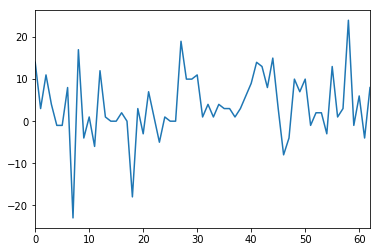

In [35]:
# sentiment scores over time ...

corpus_df.Score.plot()

## Explore Most Positive/Negative Quotes

In [36]:
# Quotes with highest sentiment score = most positive

# some hits and some misses

# Idx  8 - not sure, it is strongly positive
# Idx 12 - more cautionary than positive
# Idx 11 - tone is positive (the implications may not be so positive for us)

corpus_df[['Quote', 'Attribution', 'Sentiment', 'Score', 'Emotions']] \
    .sort_values('Score', ascending=False) \
    .head(5)

,Quote,Attribution,Sentiment,Score,Emotions
58,If we can achieve true consciousness in machines ... then we can teach them to care.,"David Hanson Jr., founder and Chief Executive Officer of Hanson Robotics Ltd.",Positive,24,joy positive surprise trust
27,"So just as art for us as humans is a way of helping us get inside the mind of another human, maybe art produced by AI will help us get inside the workings of this code that is quite mysterious.","Marcus du Sautoy, mathematician and professor at Oxford University",Positive,19,anticipation fear joy positive sadness surprise
8,It will be the job of the next Commission to deliver something so that we have regulation similar to the General Data Protection Regulation that makes it clear that artificial intelligence serves humanity.,"German Chancellor Angela Merkel, according to Politico.",Positive,17,fear joy positive trust
44,"As much as I love Elon, and he's a great entrepreneur and a friend, his comic-book vision of a future in which an artificial superintelligence takes over everything and enslaves the human race is probably not what we should be worrying about.","Napster co-founder Sean Parker, referring to Elon Musk on CNBC.",Positive,15,anticipation fear joy negative positive sadness trust
41,"My view is that A.I., if provided with transparency, will ultimately allow all industries to leverage the best of humans and machines together to create better, safer and smarter solutions for customers.","Adena Friedman, Nasdaq president and chief executive.",Positive,14,anticipation joy positive trust


In [37]:
# Quotes with lowest sentiment score = most negative

# more hits and misses
# Idx 46 - I don't see focus of AI competition in semiconductor industry as a negative sentiment
# Idx 23 - not negative, actually kind of humorous to think about
# Idx 61 - unclear if humanization of AI is good thing or bad thing

corpus_df[['Quote', 'Attribution', 'Sentiment', 'Score', 'Emotions']] \
    .sort_values('Score', ascending=True) \
    .head(5)

,Quote,Attribution,Sentiment,Score,Emotions
7,"What if you get a cancer diagnosis, or you get a [reading] saying you're cancer free, and it turns out you have cancer -- who is going to be accountable for that?","Microsoft Cybersecurity Field CTO Diana Kelley speaking about AI decision-making at a recent RSA Security conference, according to ZDNet.",Negative,-23,anger anticipation disgust fear negative positive sadness trust
18,"Imagine the outrage if, upon dying, our bodies, thoughts and possessions could be taken and used in perpetuity by private enterprises. But that's essentially what we've allowed the digital world to do.","Darren Shou, vice president of research at Symantec.",Negative,-18,anger anticipation disgust fear negative positive sadness trust
46,"Other than military AI applications, the future focus of strategic national AI competition is likely to be the semiconductor industry, because the cutting edge of AI technology increasingly depends on custom computer chips.",Center for a New American Security,Negative,-8,anger anticipation disgust fear negative positive sadness
11,A good AI has a ridiculously unfair advantage against humans: They don't get tired. They don't get hungry. They don't deal with emotions.,"Michael ""Gags"" Gagliano, a professional poker player who lost to Pluribus",Negative,-6,anger anticipation disgust joy negative positive sadness surprise trust
23,It's not like you can tell a donkey to stand still and raise its chin up slightly.,"Chen Zenghui, product director at animal-recognition software company Innovationai Co.",Negative,-5,disgust negative positive


## 2C. Gather Some Data for Presentation

In [38]:
sentiment_df = corpus_df[['Date','Quote', 'Attribution', 'Sentiment', 'Score']]

# --------------------------------------------------------------------
# # UNCOMMENT! TO SAVE CONTENTS TO .CSV FILE (when desired)
# # save result to a file
sentiment_df.to_csv('quotes_sentiment.csv', index=True)
# --------------------------------------------------------------------